## Modeling ##

In [1]:
import time
import pickle
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import Colormap
import scipy.stats as stats
from numpy import interp
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV, 
    cross_val_score, 
    cross_val_predict
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    r2_score,
    mean_squared_error, 
    root_mean_squared_error,
    mean_absolute_error, 
    mean_absolute_percentage_error,
    accuracy_score,
    matthews_corrcoef,
    brier_score_loss,
    f1_score,
    roc_curve, 
    roc_auc_score
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\Python\big-g-big-rigs


This notebook is dedicated to the feature selection and statistical modeling of our trucking data.

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('data/data_clean_05_08.csv', low_memory=False)

Cleaning features and reassigning them to the proper dtypes

In [5]:
columns_to_object = ['ecuSource',
                     'spn',
                     'fmi',
                     'MCTNumber',
                     'RecordID',
                     'ESS_Id'
                    ]

for column in columns_to_object:
    df[column] = df[column].astype(object)

In [6]:
columns_to_bool = ['CruiseControlActive',
                   'IgnStatus',
                   'ParkingBrake']

for column in columns_to_bool:
    df[column] = df[column].astype(bool)

In [7]:
int64_cols = df.select_dtypes(include='bool').columns
df[int64_cols] = df[int64_cols].astype('int64')

Separating the test and training data.

In [8]:
test_date = '2019-01-01'

df_test = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] > test_date]

In [9]:
df_train = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] < test_date]

In [10]:
#df = df.sample(frac=0.50)

Scaling and encoding features for modeling.

In [11]:
X_train = df_train.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd'
            ], axis=1)

y_train = df_train['target']

In [12]:
X_test = df_test.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd'
            ], axis=1)

y_test = df_test['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 27, train_size = 0.6/0.8)

Selection of features for each step of the pipeline. The last few lines are for checking to make sure each feature is accounted for.

In [13]:
ohe_features = ['spn',
                'fmi',
                'ecuSource'
                ] 

bool_features = ['CruiseControlActive',
                 'IgnStatus',
                 'ParkingBrake',
                 'active'
                ]

scale_features = [
                  'AcceleratorPedal',
                  'BarometricPressure',
                  'EngineCoolantTemperature',
                  'EngineOilPressure',
                  'EngineOilTemperature',
                  'EngineRpm',
                  'FuelLevel',
                  'activeTransitionCount',
                  'FuelLtd',
                  'FuelTemperature',
                  'IntakeManifoldTemperature',
                  'Speed',
                  'FuelRate',
                  'EngineTimeLtd',
                  'Throttle'
                 ]

everything = list(set(ohe_features + bool_features + scale_features))
the_rest = X_train.columns.difference(everything)
pca = PCA(n_components = 5)

In [14]:
%%time

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ii', IterativeImputer(initial_strategy = 'mean',
                           max_iter = 30,
                           sample_posterior = True))
])

categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(categories='auto', 
                          handle_unknown = 'ignore')),
    ('si', SimpleImputer(strategy = 'most_frequent'))
])

boolean_pipeline = Pipeline([
    ('ii', IterativeImputer(initial_strategy = 'most_frequent',
                           max_iter = 30,
                           sample_posterior = True))
])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, scale_features),
        ('cat', categorical_pipeline, ohe_features),
        ('bool', boolean_pipeline, bool_features)
    ],
    remainder='drop'
)

pipe = Pipeline(
    steps=[
        ('transformer', ct)
    ])

pipe.fit(X_train, y_train)

CPU times: total: 10min 22s
Wall time: 6min 4s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('ii',
                                                                   IterativeImputer(max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['AcceleratorPedal',
                                                   'BarometricPressure',
                                                   'EngineCoolantTemperature',
                                                   'EngineOilPressure',
                                                   'EngineOilTemperature',
                                                   'EngineRpm', 'FuelLevel',
                                                   'activeTransitionCount',
                                                   'FuelLtd', 'FuelT...
                                                   'EngineTimeLtd',
                                                   'Throttle']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('si',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['spn', 'fmi', 'ecuSource']),
                                                 ('bool',
                                                  Pipeline(steps=[('ii',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['CruiseControlActive',
                                                   'IgnStatus', 'ParkingBrake',
                                                   'active'])]))])

The above cell takes 11 minutes to fit the pipe, and the cell below takes 4 minutes to transform the pipe.

In [15]:
%%time

X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test) 

CPU times: total: 4min 15s
Wall time: 2min 52s


In [61]:
smote = SMOTE(
    sampling_strategy = 'minority'
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

Transformation of pipe and saving the pipe as a pickle object so that the pipe doesn't need to be fitted again.

In [17]:
filename = 'pipe_transformed.pkl'

pickle_list = [pipe, X_train_balanced, X_test_transformed, y_train_balanced]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [18]:
filename = 'pipe_transformed.pkl'

with open(filename, 'rb') as file:
    pipe, X_train_balanced, X_test_transformed, y_train_balanced = pickle.load(file)

Applying the pipe transformations to models to see which model performs best.

%%time

knn_model = KNeighborsClassifier().fit(X_train_balanced, y_train_balanced)

%%time

y_pred_knn = knn_model.predict(X_test_transformed)

filename = 'knn.pkl'

pickle_list = [y_pred_knn, knn_model]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'knn.pkl'

with open(filename, 'rb') as file:
    knn_model, y_pred_knn = pickle.load(file)

Prediction on KNeighborsClassifier takes a while

print(f'Accuracy: {accuracy_score(y_test, y_pred_knn)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_knn)}')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division = 0))
#print(cross_val_score(knn_model, X_train_transformed, y_train, cv=3))

Cells below use hyperopt for hyperparameter tuning of xgboost

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']),
                    eval_metric="auc",
                    early_stopping_rounds=10)
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test_transformed, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [62]:
%%time

xgbm = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    colsample_bytree = 0.9179993452534458,
    gamma = 3.55507468819673,
    max_depth = 17,
    min_child_weight = 9,
    reg_alpha = 62,
    n_estimators = 100,
    reg_lambda = 0.5990326545008506,
    scale_pos_weight = 2
).fit(X_train_balanced, y_train_balanced)

y_pred_xgbm = xgbm.predict(X_test_transformed)

CPU times: total: 4min 29s
Wall time: 23.3 s


Cell below allowed for the feature importance graphing of scaled features, but is broken when all features are selected

xgbm.get_booster().feature_names = scale_features

plot_importance(xgbm)
plt.figure(figsize = (16, 12))
#plt.savefig("graphs/feature_importance.png")
plt.show();

In [20]:
filename = 'xgbm.pkl'

pickle_list = [y_pred_xgbm, xgbm]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [21]:
filename = 'xgbm.pkl'

with open(filename, 'rb') as file:
    y_pred_xgbm, xgbm = pickle.load(file)

In [63]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgbm)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_xgbm)}')
print(confusion_matrix(y_test, y_pred_xgbm))
print(classification_report(y_test, y_pred_xgbm, zero_division = 0))

Accuracy: 0.9921428635495242
MCC: 0.1144354097881846
[[110561    619]
 [   257     54]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    111180
           1       0.08      0.17      0.11       311

    accuracy                           0.99    111491
   macro avg       0.54      0.58      0.55    111491
weighted avg       1.00      0.99      0.99    111491



In [23]:
probas = xgbm.predict_proba(X_test_transformed)

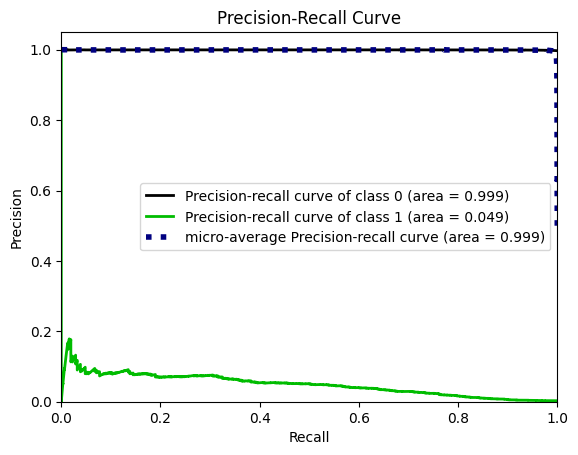

In [24]:
skplt.metrics.plot_precision_recall(y_test, probas)
#plt.savefig("graphs/precision_recall_curve.png")
plt.show()

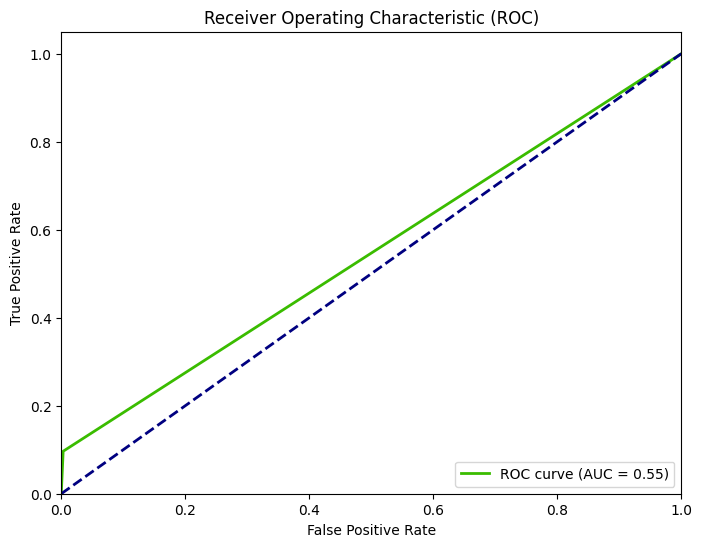

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgbm)
roc_auc = roc_auc_score(y_test, y_pred_xgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3ABC00', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig("graphs/roc_curve.png")
plt.show();

In [26]:
def target_pred(df, event, equipment, target, pred):
    df = df[[event, equipment, target]].copy()
    df['predict'] = pred
    df[event] = pd.to_datetime(df[event])
    df = df.sort_values(by=[equipment, event])
    df['time_diff'] = df.groupby(equipment)[event].diff().dt.total_seconds() / 3600
    df['valid_group'] = (df['time_diff'].isna()) | (df['time_diff'] <= 2)
    df['temp_group'] = (~df['valid_group']).cumsum()
    df['combined'] = df[target].astype(str) + '_' + df['predict'].astype(str)
    
    result = df.groupby([equipment, 'temp_group'])['combined'].value_counts().reset_index(name='count')
    result = result.groupby(equipment)['combined'].value_counts().unstack(fill_value=0).drop_duplicates()
    result = result.rename(columns = {'0_0': 'true negative', '0_1': 'false positive', '1_0': 'false negative', '1_1': 'true positive'})
    counts = (result.iloc[:,0].sum() * 0) - (result.iloc[:,1].sum() * 500) - (result.iloc[:,2].sum() * 4000) + (result.iloc[:,3].sum() * 4000)
    return counts

In [64]:
target_pred(df_test, 'EventTimeStamp', 'EquipmentID', 'target', y_pred_xgbm)

np.int64(-318000)

In [28]:
%%time

rfc = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=27).fit(X_train_balanced, y_train_balanced)

y_pred_rfc = rfc.predict(X_test_transformed)

CPU times: total: 16.3 s
Wall time: 16.3 s


In [29]:
filename = 'rfc.pkl'

pickle_list = [y_pred_rfc, rfc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [30]:
filename = 'rfc.pkl'

with open(filename, 'rb') as file:
    y_pred_rfc, rfc = pickle.load(file)

In [31]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_rfc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_rfc)}')
print(confusion_matrix(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc, zero_division = 0))

Accuracy: 0.8588226852391673
MCC: 0.08313765374934395
[[95536 15644]
 [   96   215]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    111180
           1       0.01      0.69      0.03       311

    accuracy                           0.86    111491
   macro avg       0.51      0.78      0.48    111491
weighted avg       1.00      0.86      0.92    111491



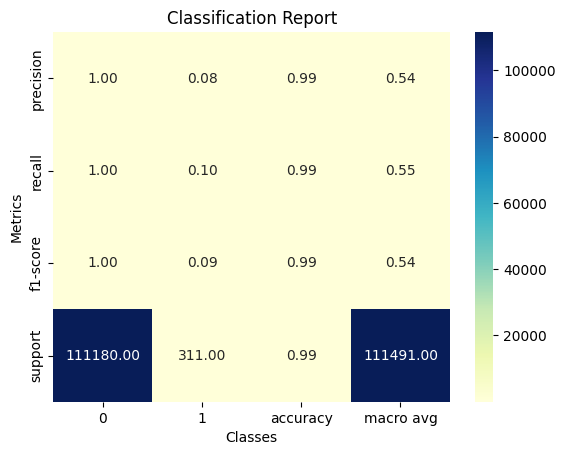

In [32]:
report = classification_report(y_test, y_pred_xgbm, output_dict=True)
df_report = pd.DataFrame(report).transpose()
    
fig, ax = plt.subplots()
sn.heatmap(df_report.iloc[:-1, :].T, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)

plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
#plt.savefig("graphs/classification_report.png")
plt.show();

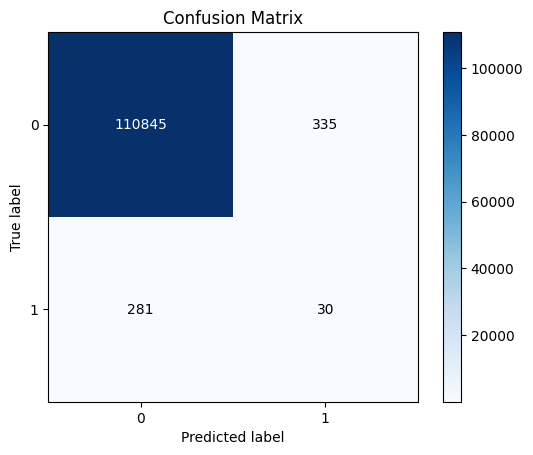

In [33]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgbm, normalize=False)
#plt.savefig("graphs/confusion_matrix.png")
plt.show()

In [34]:
%%time

logreg = LogisticRegression(max_iter=10000).fit(X_train_balanced, y_train_balanced)

y_pred_logreg = logreg.predict(X_test_transformed)

CPU times: total: 1min 27s
Wall time: 1min 27s


In [35]:
filename = 'logreg.pkl'

pickle_list = [y_pred_logreg, logreg]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [36]:
filename = 'logreg.pkl'

with open(filename, 'rb') as file:
    y_pred_logreg, logreg = pickle.load(file)

In [51]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_logreg)}')
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg, zero_division = 0))

Accuracy: 0.8338161824721277
MCC: 0.09268611147616317
[[92707 18473]
 [   55   256]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    111180
           1       0.01      0.82      0.03       311

    accuracy                           0.83    111491
   macro avg       0.51      0.83      0.47    111491
weighted avg       1.00      0.83      0.91    111491



In [38]:
df_test['predictions'] = y_pred_logreg

In [39]:
pred_df = df_test[['EventTimeStamp', 'EquipmentID', 'spn', 'target', 'predictions']]

In [40]:
pred_df[(pred_df['target'] == 1) & (pred_df['predictions'] == 1)].drop_duplicates()

,EventTimeStamp,EquipmentID,spn,target,predictions
949513,2019-01-13 11:58:11,1698,4340,1,1
949512,2019-01-13 11:58:11,1698,6802,1,1
949526,2019-01-13 13:13:23,1698,1569,1,1
952402,2019-01-21 03:54:10,1827,1569,1,1
952403,2019-01-21 04:20:26,1827,1569,1,1
...,...,...,...,...,...
1052160,2020-02-13 08:32:46,1872,1569,1,1
1052158,2020-02-13 08:32:46,1872,3364,1,1
1052161,2020-02-13 08:32:46,1872,1761,1,1
1052233,2020-02-13 11:32:18,1872,5835,1,1


y_val_pred_proba = pipe.predict_proba(X_val)[:,1]

candidate_thresholds = np.arange(start = 0.1, stop = 0.925, step = 0.01)
thresholds = pd.DataFrame({'threshold': candidate_thresholds})
thresholds['f1'] = thresholds['threshold'].apply(lambda x: f1_score(y_val, y_val_pred_proba > x))
thresholds.sort_values('f1', ascending = False).head()

threshold = 0.10

y_pred_proba = model.predict_proba(X_test_transformed)[:,1]

y_pred = y_pred_proba > threshold
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [52]:
target_pred(df_test, 'EventTimeStamp', 'EquipmentID', 'target', y_pred_logreg)

np.int64(-4673500)

In [41]:
#param_grid = {
#    'preprocessor__num__scaler__with_mean': [True, False],
#    'preprocessor__num__scaler__with_std': [True, False],
#    'classifier__C': [0.1, 1, 10],
#    'classifier__solver': ['liblinear', 'newton-cg']
#}

#randomized_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=3)

%%time

hgbc = HistGradientBoostingClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_hgbc = hgbc.predict(X_test_transformed)

confusion_matrix(y_test, y_pred_hgbc)

print(classification_report(y_test, y_pred_hgbc, zero_division = 0))

In [42]:
%%time

dtc = DecisionTreeClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_dtc = dtc.predict(X_test_transformed)

CPU times: total: 11min 3s
Wall time: 11min 5s


In [43]:
filename = 'dtc.pkl'

pickle_list = [y_pred_dtc, dtc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [44]:
filename = 'dtc.pkl'

with open(filename, 'rb') as file:
    y_pred_dtc, dtc = pickle.load(file)

In [45]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_dtc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_dtc)}')
print(confusion_matrix(y_test, y_pred_dtc))
print(classification_report(y_test, y_pred_dtc, zero_division = 0))

Accuracy: 0.9928155635880923
MCC: 0.07137901548777932
[[110659    521]
 [   280     31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111180
           1       0.06      0.10      0.07       311

    accuracy                           0.99    111491
   macro avg       0.53      0.55      0.53    111491
weighted avg       0.99      0.99      0.99    111491



%%time

svm = SVC(kernel='linear', C=1.0, gamma='auto', probability=True)

svm.fit(X_train_balanced, y_train_balanced)

y_pred_svm = svm.predict(X_test_transformed)

filename = 'svm.pkl'

pickle_list = [y_pred_svm, svm]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'svm.pkl'

with open(filename, 'rb') as file:
    y_pred_svm, svm = pickle.load(file)

print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_svm)}')
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division = 0))

In [46]:
%%time

lgb = LGBMClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_lgb = lgb.predict(X_test_transformed)

[LightGBM] [Info] Number of positive: 943351, number of negative: 943351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.836392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26233
[LightGBM] [Info] Number of data points in the train set: 1886702, number of used features: 321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 1min 27s
Wall time: 11.7 s


C:\Users\cavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [47]:
filename = 'lgb.pkl'

pickle_list = [y_pred_lgb, lgb]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [48]:
filename = 'lgb.pkl'

with open(filename, 'rb') as file:
    y_pred_lgb, lgb = pickle.load(file)

In [49]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_lgb)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_lgb)}')
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, zero_division = 0))

Accuracy: 0.9755226879299674
MCC: 0.20616397323028463
[[108564   2616]
 [   113    198]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    111180
           1       0.07      0.64      0.13       311

    accuracy                           0.98    111491
   macro avg       0.53      0.81      0.56    111491
weighted avg       1.00      0.98      0.99    111491



C:\Users\cavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


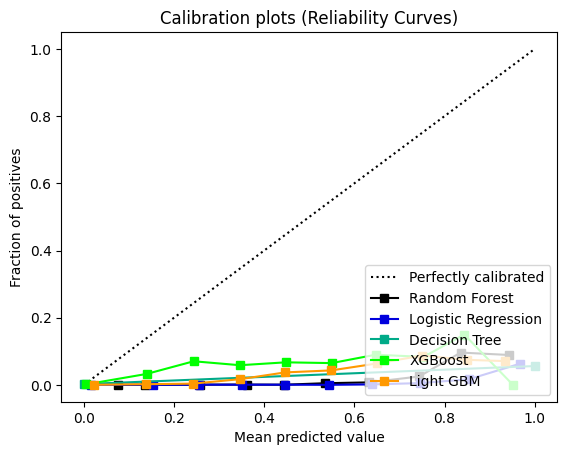

CPU times: total: 4.81 s
Wall time: 719 ms


In [50]:
%%time

rf_probas = rfc.predict_proba(X_test_transformed)
lr_probas = logreg.predict_proba(X_test_transformed)
dtc_probas = dtc.predict_proba(X_test_transformed)
xgbm_probas = xgbm.predict_proba(X_test_transformed)
lgb_probas = lgb.predict_proba(X_test_transformed)
probas_list = [rf_probas, 
               lr_probas, 
               dtc_probas, 
               xgbm_probas, 
               lgb_probas]
clf_names = ['Random Forest', 
             'Logistic Regression',
             'Decision Tree', 
             'XGBoost',
             'Light GBM']
skplt.metrics.plot_calibration_curve(y_test,
                                     probas_list,
                                     clf_names)
#plt.savefig("graphs/calibration_curve.png")
plt.show()